# treatment

The treatment table allows users to document, in a structured format, specific active treatments for the patient. The treatment table can only be populated directly into eCareManager as structured text. Absence of a treatment documented in this table should not be used as evidence a specific treatment was not administered. Data includes patient treatment information such as when the treatment occurred, whether the treatment was active upon patient discharge, and the path of the treatment.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine
con= create_engine('postgresql://eicu@localhost:5432/eicu')

## Examine a single patient

In [4]:
patientunitstayid = 242040

In [5]:
query = query_schema + """
select *
from treatment
where patientunitstayid = {}
order by treatmentoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,treatmentid,patientunitstayid,treatmentoffset,treatmentstring,activeupondischarge
0,9472063,242040,198,infectious diseases|medications|therapeutic an...,False
1,10207446,242040,198,cardiovascular|consultations|Cardiology consul...,False
2,9164625,242040,198,cardiovascular|non-operative procedures|diagno...,False
3,8399138,242040,198,cardiovascular|hypertension|angiotensin II rec...,False
4,9784345,242040,198,endocrine|glucose metabolism|insulin,False


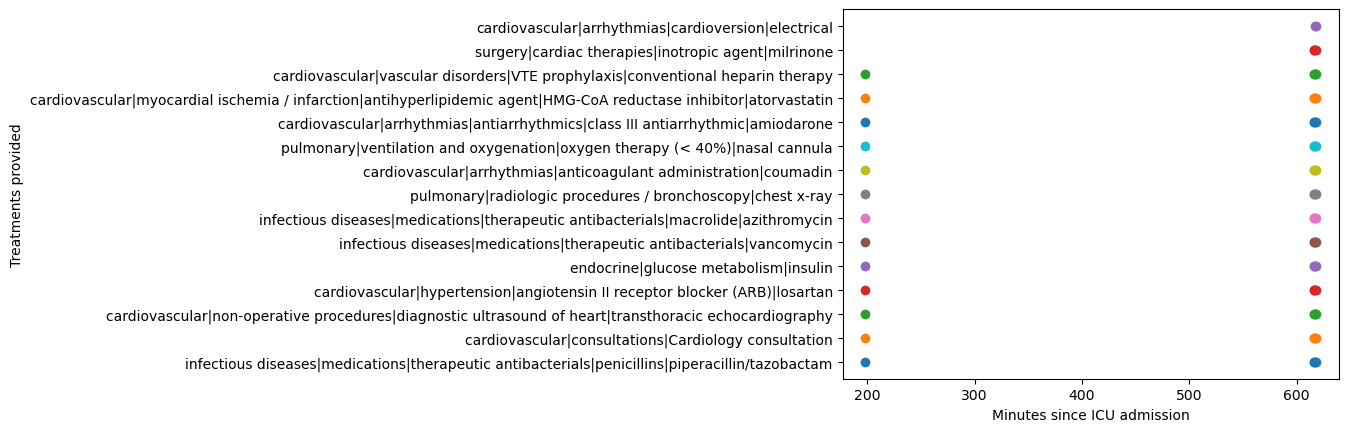

In [7]:
plt.figure()

treatments = df['treatmentstring'].unique()

for i, t in enumerate(treatments):
    idx = df['treatmentstring'] == t
    df_plt = df.loc[idx, :]
    plt.plot( df_plt['treatmentoffset'], i*np.ones(df_plt.shape[0]), 'o',
             label=t)
plt.xlabel('Minutes since ICU admission')
plt.ylabel('Treatments provided')

plt.yticks(np.arange(len(treatments)), treatments)

plt.show()

Above we can see that most of these treatments were documented as being given twice (or perhaps continuously given over the duration - the interpretation is not clear). Only milrinone and cardioversion were given once around 620 minutes after ICU admission.

## Hospitals with data available

In [8]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from treatment
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
106,264,5237,4857,92.743937
134,338,4277,4217,98.597148
90,243,4243,4089,96.370493
200,443,3656,3597,98.386214
122,300,3617,3542,97.926458
80,208,3650,3425,93.835616
184,420,4679,3279,70.079077
206,458,3701,3240,87.543907
71,199,4240,3151,74.316038
177,411,3199,2908,90.903407


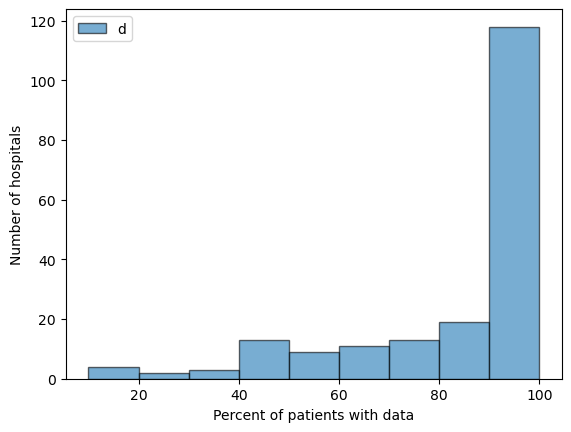

In [14]:
bins=[10,20,30,40,50,60,70,80,90,100]
plt.hist(df['data completion'], bins=bins,alpha=0.6, stacked = False ,edgecolor='black')
plt.legend('data completion')
plt.xlabel('Percent of patients with data')
plt.ylabel('Number of hospitals')
plt.show()

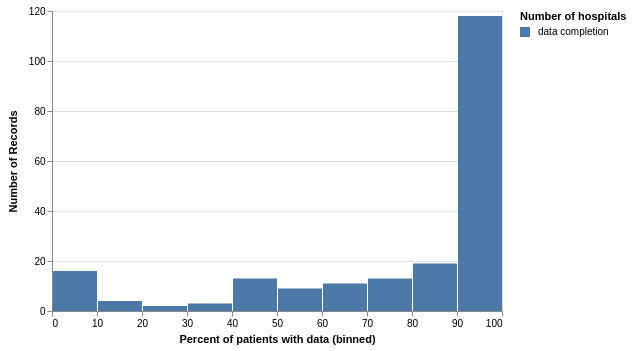

In [7]:
df[['data completion']].vgplot.hist(bins=10,
                                    var_name='Number of hospitals',
                                    value_name='Percent of patients with data')

The treatment table is fairly frequently used in eICU-CRD, with the majority of hospitals having some form of data in it. Of course, this is not a guarantee that the table contains reliable treatment documentation for all treatments performed during the patient's stay.